# Plane Ticket Prices

![A silhouette of an old-fashioned airplane flying against the pastel tan/yellow cloudy sunset.](airplane.jpg)

I found a really good [dataset](https://data.transportation.gov/Aviation/Consumer-Airfare-Report-Table-1-Top-1-000-Contiguo/4f3n-jbg2/about_data) from the Bureau of Transportation Statistics (BTS) titled "Consumer Airfare Report: Table 1 - Top 1,000 Contiguous State City-Pair Markets." It had decent a number of numeric variables on top of being an official government dataset, so I thought I'd give it a shot.

The dataset is from a BTS report on consumer airfare prices, specifically focusing only on the mainland US in the top 1,000 city-pair markets. According to the [BTS website](https://www.transportation.gov/policy/aviation-policy/air-fare-information-consumers), "these markets account for about 75 percent of all 48-state passengers and 70 percent of total domestic passengers." So, with this project, I was hoping to create a model to predict airplane prices for the whole US given some other variables, like number of miles, and passengers.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
from sklearn import tree

## The data

In [2]:
df = pd.read_csv("ticket-prices.csv"); df

,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,table_1_flag,Geocoded_City1,Geocoded_City2
0,2024,3,32575,32457,"Los Angeles, CA (Metropolitan Area)","San Francisco, CA (Metropolitan Area)",372,16339,159.59,WN,0.5209,170.76,AS,0.1219,148.79,-1,NaN,NaN
1,2024,3,32467,31703,"Miami, FL (Metropolitan Area)","New York City, NY (Metropolitan Area)",1118,15842,179.57,B6,0.2565,161.00,NK,0.1149,105.45,-1,NaN,NaN
2,2024,3,32575,31703,"Los Angeles, CA (Metropolitan Area)","New York City, NY (Metropolitan Area)",2510,13767,399.68,B6,0.2642,347.36,B6,0.2642,347.36,-1,NaN,NaN
3,2024,3,31703,31454,"New York City, NY (Metropolitan Area)","Orlando, FL",989,12511,176.63,B6,0.4043,174.50,NK,0.1197,115.86,-1,NaN,NaN
4,2024,3,30977,31703,"Chicago, IL","New York City, NY (Metropolitan Area)",773,11466,184.79,UA,0.4137,203.27,WN,0.1059,147.50,-1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,2024,1,33570,30436,"San Diego, CA","Tucson, AZ",368,198,208.98,WN,0.8454,202.19,WN,0.8454,202.19,-1,NaN,NaN
2997,2024,1,31454,33728,"Orlando, FL","Pensacola, FL",381,197,134.51,NK,0.6011,88.68,NK,0.6011,88.68,-1,NaN,NaN
2998,2024,1,31057,31136,"Charlotte, NC","Jacksonville, FL",328,197,274.20,AA,0.9509,275.09,DL,0.0452,253.71,-1,NaN,NaN
2999,2024,1,32467,34685,"Miami, FL (Metropolitan Area)","Savannah, GA",440,197,226.85,AA,0.7041,230.84,AA,0.7041,230.84,-1,NaN,NaN


I downloaded data only from 2024, which gives me 3001 rows, a good number to model with. Each row in the dataset is a snapshot of a single city-pair market at a given year and quarter.

In [3]:
# Combine all predictor variables into a new dataframe
X = df[["nsmiles", "passengers", "large_ms", "lf_ms"]]
# We are predicting airplane ticket fares
Y = df["fare"].to_numpy()

As I said earlier, I want my predicted variable to be `fare`, which is the overall average fare (ticket price).

I focused on four predictor variables:

1. `nsmiles` (non-stop market miles), a metric of the distance covered by the route
2. `passengers`, the passenger count per day
3. `large_ms`, the market share of the carrier with the largest market share that flies this route
4. `lf_ms`, the market share of the carrier with the lowest fare for this route

Market share means the percentage of the market for the current city-pair market that the given airline controls.

## BART Model

The first model I made was a BART model, guided by the exercises and notes.

### Prior, likelihood, posterior

As usual, I want a weak prior due to my lack of knowledge of the topic. For likelihood, I tried both Normal and Gamma, and both gave the same results, so I decided to use Normal because it makes less assumptions. I toyed with other parameters, but the model seemed to work quite well with the parameters found in the notes.

In [4]:
# BART Model
with pm.Model() as model:
    s = pm.HalfNormal("s", 20) # A value of 20 seems to work well
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) # BART Model
    μ = pm.Deterministic("μ", pm.math.exp(μ_)) # Our data is nonnegative, so we can exp it
    y = pm.Normal("y", mu=μ, sigma=s, observed=Y) # A normal likelihood seems to work just as well as a gamma likelihood
    idata = pm.sample(compute_convergence_checks=False) # Sample from the model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [s]
>PGBART: [μ_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.


In [5]:
pm.sample_posterior_predictive(idata, model, extend_inferencedata=True)

Sampling: [y]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

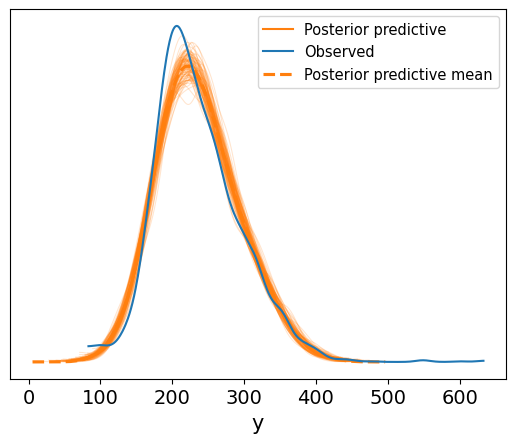

In [6]:
ax = az.plot_ppc(idata, num_pp_samples=100, colors=["C1", "C0", "C1"])

I used the PPC to confirm the utility of the model. It works pretty well, although the peak is slightly off from the observed data. I decided that it was good enough to analyze using the other plotting tools we learned about.

### Analysis of variables

The first thing I did was trying to plot the posterior predictive for a single relationship between two variables, `nsmiles` and `fare`.

In [7]:
# Format the posterior to plot it
posterior_mean = idata.posterior["μ"]

μ_hdi = az.hdi(ary=idata, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata, group="posterior_predictive", var_names=["y"]
).T

/home/maxim/school/lasa/2024-2025/data-science/data-science-fundamentals/venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


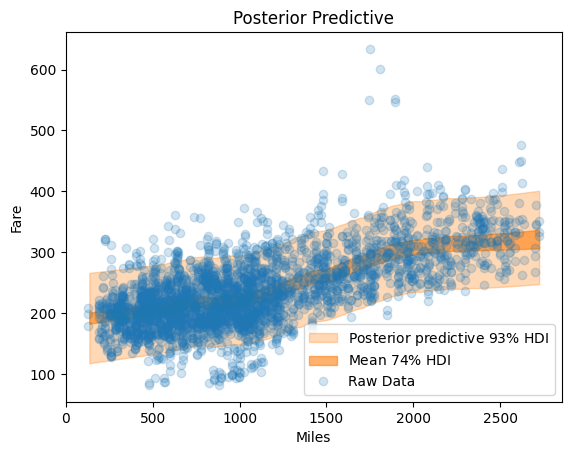

In [8]:
idx = np.argsort(X.to_numpy()[:, 0]) # Grab 0th row, since that is `nsmiles`
fig, ax = plt.subplots() # Create a plot

# Plot the PPC at 93% HDI
az.plot_hdi(
    x=X.to_numpy()[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior predictive $93\%$ HDI"},
)

# Plot the PPC at 74% HDI
az.plot_hdi(
    x=X.to_numpy()[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)

# Plot the raw data
ax.plot(df['nsmiles'], df["fare"], "o", c="C0", alpha=0.2, label="Raw Data")

# Add a legend to the plot
ax.legend(loc="lower right")

# Labels
ax.set(
    title="Posterior Predictive",
    xlabel="Miles",
    ylabel="Fare",
);

The graph shows that the model does a good job at predicting this relationship. The posterior predictive mean is centered on the data, and the 93% HDI does a good job of capturing most data points, except for a smaller portion of outliers. This shows that the model doesn't seem to overfit, which is good, because it still captures the overall trend in the data. Next, I did a PDP plot.

array([<Axes: xlabel='nsmiles'>, <Axes: xlabel='passengers'>,
       <Axes: xlabel='large_ms'>, <Axes: xlabel='lf_ms'>], dtype=object)

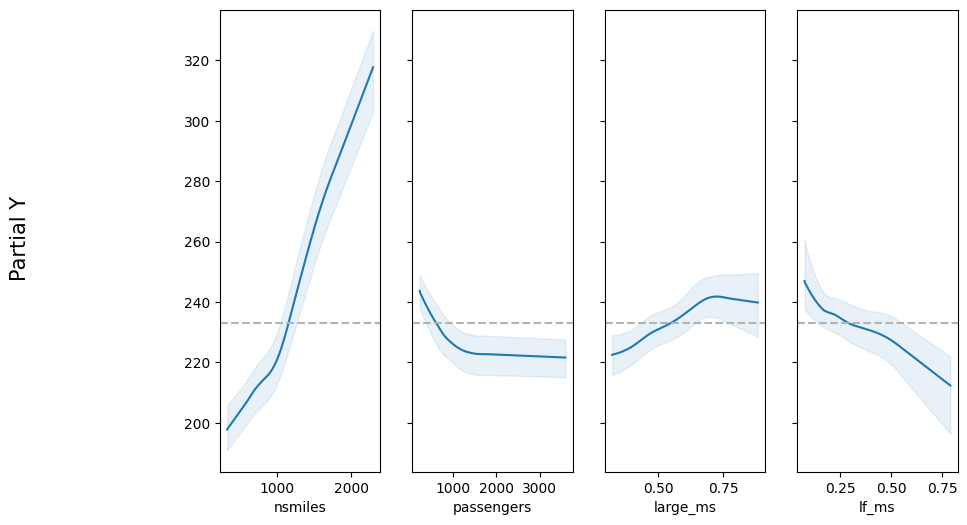

In [9]:
# PDP Plot
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

Based on just this graph, here are my observations:

- `nsmiles`: An upward-sloping linear relationship. There seem to be two slopes, with the second one being steeper at around the 1,000 mile mark. The longer the trip, the higher the fare, and this is especially true for trips over 1,000 miles.
- `passengers`: A downward-sloping linear relationship until the 1,000 passenger mark, and then an almost-horizontal line. At very small amounts of passengers, fares are significantly higher, but otherwise passenger counts don't affect fares as much.
- `large_ms`: An upward-sloping line until 0.75, and then a slightly downward-sloping line. This shows that if the the carrier with the largest market share is a big player in the market, prices tend to be higher.
- `lf_ms`: A downward-sloping line. This shows that the larger the market share of the carrier with the lowest fare, the lower the fare will be.

Of course, the analysis would be incomplete without an ICE plot:

array([<Axes: xlabel='nsmiles'>, <Axes: xlabel='passengers'>,
       <Axes: xlabel='large_ms'>, <Axes: xlabel='lf_ms'>], dtype=object)

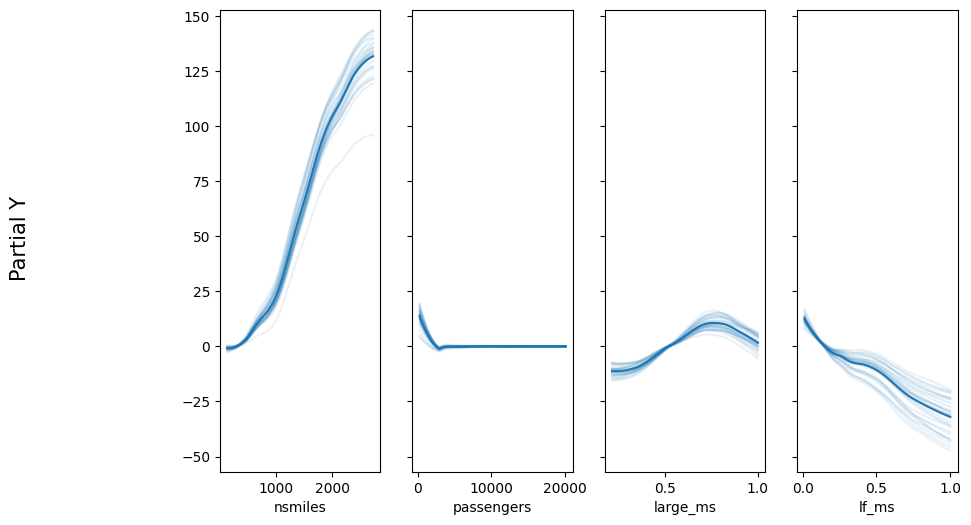

In [10]:
# ICE Plot
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

Here is my analysis given the new information from the ICE plot:

- `nsmiles`: The lines tend to be parallel, although they grow apart at large route distances. So `nsmiles` on its own predicts fares very well, but at higher values, other factors might determine them better.
- `passengers`: The lines are mostly parallel. If the number of passengers is very low, then that is a good indicator that fares will be higher. Otherwise, passenger count is a less useful metric.
- `large_ms`: The lines are more or less parallel, although significantly moreso at around 50% market share. Still, the larger carrier's market share works pretty well to make determinations from around 0% to 75%. When the market share of the carrier with the largest market share is low, that indicates that no single carrier significantly dominates the market. This makes sense because competition drives down prices, while monopolies keep prices high. However, this isn't so true from 75% to 100% market share, probably because the carrier is still bound by prices in other markets (just because a single carrier might fly a route doesn't mean that they can raise prices to extremely high levels because it would be an outlier in the broader US airline market.
- `lf_ms`: The lines are parallel at small values, but then diverge significantly afterwards, indicating an interaction. What we know with more certainty is that when the carrier with the lowest fare is a small player in the market, the fare will be high. I don't know the reason behind this. It could be that it means that the carrier controls and insignificant part of the market, and so there is no incentive for competitors to lower prices.

<Axes: ylabel='R²'>

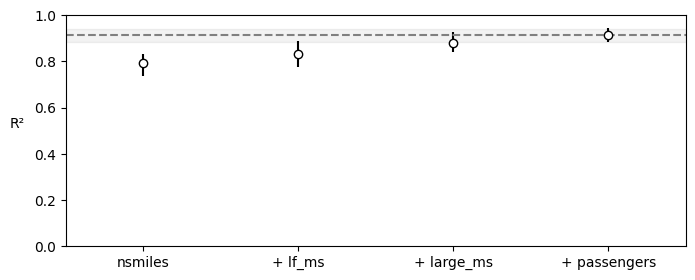

In [11]:
# Variable Importance Plot
vi = pmb.compute_variable_importance(idata, μ_, X)
pmb.plot_variable_importance(vi)

All variables have high $R^2$ values, and the distance between them seems insignificant, so I didn't really make any determinations from this graph.

In conclusion, `nsmiles` seems to be the best indicator of fare due to there being a clear trend and little interaction with other variables. The other three variables serve to refine the price for certain edge cases (such as extremely small passenger counts), but the trends are less simple and interactions are more prevalent, so they might needlessly complicate the model.

## Decision Tree Model

Having found that `nsmiles` is a good indicator of `fare`, I decided to create a decision tree just to see how well it owuld work.

In [12]:
# We chose miles for our predictor
X = df["nsmiles"].to_numpy().reshape(-1, 1)
# Fare is the predicted variable
Y = df["fare"].to_numpy()

In [13]:
# Fit a decision tree. Max depth of 3 does a good job without overfitting.
dtree = tree.DecisionTreeRegressor(max_depth=3)
octtree = dtree.fit(X,Y)

# Use the fitted model to make predictions
X_test = np.arange(0, 3000, 1)[:, np.newaxis]
y = octtree.predict(X_test)

[Text(0.5, 0.875, 'x[0] <= 1339.5\nsquared_error = 3512.862\nsamples = 3001\nvalue = 235.837'),
 Text(0.25, 0.625, 'x[0] <= 1016.0\nsquared_error = 1886.026\nsamples = 2193\nvalue = 213.425'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[0] <= 623.0\nsquared_error = 1676.554\nsamples = 1653\nvalue = 208.1'),
 Text(0.0625, 0.125, 'squared_error = 1296.935\nsamples = 781\nvalue = 201.719'),
 Text(0.1875, 0.125, 'squared_error = 1947.431\nsamples = 872\nvalue = 213.815'),
 Text(0.375, 0.375, 'x[0] <= 1148.5\nsquared_error = 2174.7\nsamples = 540\nvalue = 229.726'),
 Text(0.3125, 0.125, 'squared_error = 2214.375\nsamples = 309\nvalue = 222.556'),
 Text(0.4375, 0.125, 'squared_error = 1960.847\nsamples = 231\nvalue = 239.318'),
 Text(0.75, 0.625, 'x[0] <= 1784.0\nsquared_error = 2864.892\nsamples = 808\nvalue = 296.665'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'x[0] <= 1580.5\nsquared_error = 2335.632\nsamples = 357\nvalue = 271.458'),
 Text(0.5625, 0.125, 'squared_error

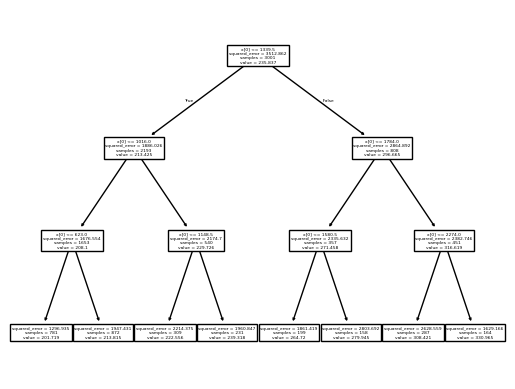

In [14]:
# Plot a diagram of the tree
tree.plot_tree(octtree)

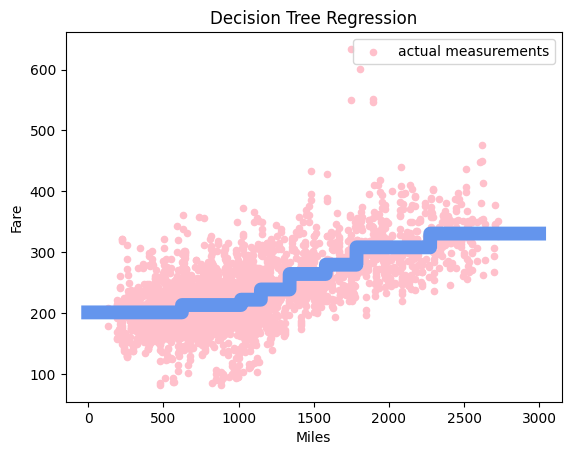

In [15]:
plt.figure()
plt.scatter(X, Y, s=20, c="pink", label="actual measurements")
plt.plot(X_test, y, color="cornflowerblue", linewidth=10)
plt.xlabel("Miles")
plt.ylabel("Fare")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

The data shows a clear upward trend, and the mean line created by the decision tree does a good job at showing it. Furthermore, the line created from the decision tree differs little from the line created by the BART model, so this simple model is very well-suited for the fare-miles relationship. That being said, if we include the other variables, we must use the BART model.

## Conclusion

This dataset was more straightforward than some of the other ones I used in previous projects. I ended up creating two working models, with their own advantages and distadvantages. Furthermore, I succeeded in the project goal of creating a model to predict airfares. I found that the number of miles is a good estimator for plane ticket prices, but that it can also be combined with passenge counts and carrier market shares to give a fuller picture. I am happy with how both models turned out.